In [1]:
from tensorflow.keras.applications import VGG16 as b #vgg16.VGG16
import numpy as np
import pandas as pd
from matplotlib import ticker
#import seaborn as sn
import PIL
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
import subprocess as sp
import os

def mask_unused_gpus(leave_unmasked=1):
  ACCEPTABLE_AVAILABLE_MEMORY = 1024
  COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"

  try:
    _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]
    memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    available_gpus = [i for i, x in enumerate(memory_free_values) if x > ACCEPTABLE_AVAILABLE_MEMORY]

    if len(available_gpus) < leave_unmasked: raise ValueError('Found only %d usable GPUs in the system' % len(available_gpus))
    os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(map(str, available_gpus[:leave_unmasked]))
  except Exception as e:
    print('"nvidia-smi" is probably not installed. GPUs are not masked', e)

mask_unused_gpus()

In [2]:
traingen = image.ImageDataGenerator(rescale=1./255)#,rotation_range=10,width_shift_range=20,height_shift_range=10,shear_range=10,horizontal_flip=True,vertical_flip=True)
validationgen = image.ImageDataGenerator(rescale=1./255)
testgen = image.ImageDataGenerator(rescale=1./255)

train = traingen.flow_from_directory("train",target_size=(500, 825), batch_size=64, shuffle=True)
val = validationgen.flow_from_directory("validation",target_size=(500, 825), batch_size=64, shuffle=False)
test=testgen.flow_from_directory("test",target_size=(500, 825), batch_size=32, shuffle=False)

Found 2049 images belonging to 16 classes.
Found 684 images belonging to 16 classes.
Found 683 images belonging to 16 classes.


In [ ]:
call_list = [tf.keras.callbacks.ModelCheckpoint(
                 filepath='./Vgg/trVgg16-{epoch:02d}-{val_categorical_accuracy:.4f}-{categorical_accuracy:.4f}.h5',
                 monitor='val_categorical_accuracy',
                 save_best_only=False,),
             
             tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.001,patience=4,),
             tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',min_delta=0.0005,patience=8,),
             
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,min_delta=0.005,),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy',factor=0.5,patience=4,min_delta=0.005,)
            ]


base = b(include_top=False,
                weights="imagenet",
                input_shape=(500, 825, 3))

x = base.output
x = layers.Flatten()(x)
#x = layers.Dropout(0.2)(x)
#x = layers.GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = layers.Dense(16, activation='selu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(x)
predictions = layers.Dense(16, activation='softmax')(x)#, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(x)

model = Model(inputs=base.input, outputs=predictions)

# this is the model we will train

for layer in base.layers:
    layer.trainable = False

model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=["categorical_accuracy","top_k_categorical_accuracy"])



history = model.fit_generator(train,
                              #callbacks=call_list,
                              steps_per_epoch=np.ceil(2049/64),
                              epochs=50,
                              verbose=2,
                              validation_data= val,
                              validation_steps=np.ceil(684/64)
                              )

#hist_df = pd.DataFrame(history.history) 
#hist_df.to_csv("histVgg16pre2.csv")


W1127 13:23:55.761807 139966767134528 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


58892288/58889256 [==============================] - 7s 0us/step
Epoch 1/50
33/33 - 85s - loss: 15.1280 - categorical_accuracy: 0.2836 - top_k_categorical_accuracy: 0.6164 - val_loss: 3.8591 - val_categorical_accuracy: 0.5950 - val_top_k_categorical_accuracy: 0.8860
Epoch 2/50
33/33 - 46s - loss: 1.1818 - categorical_accuracy: 0.8121 - top_k_categorical_accuracy: 0.9693 - val_loss: 1.6102 - val_categorical_accuracy: 0.7281 - val_top_k_categorical_accuracy: 0.9488
Epoch 3/50
33/33 - 46s - loss: 0.1383 - categorical_accuracy: 0.9580 - top_k_categorical_accuracy: 0.9956 - val_loss: 1.4649 - val_categorical_accuracy: 0.7339 - val_top_k_categorical_accuracy: 0.9488
Epoch 4/50
33/33 - 51s - loss: 0.0448 - categorical_accuracy: 0.9854 - top_k_categorical_accuracy: 0.9990 - val_loss: 1.3743 - val_categorical_accuracy: 0.7705 - val_top_k_categorical_accuracy: 0.9547
Epoch 5/50
33/33 - 47s - loss: 0.0119 - categorical_accuracy: 0.9980 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.2274 - val

In [5]:
def smooth(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

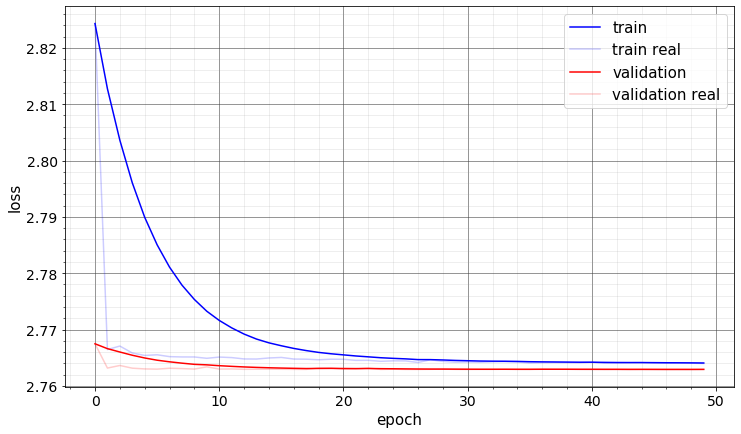

In [6]:
fig,ax=plt.subplots(figsize=(12,7))
ax.tick_params(labelsize=14)
plt.plot(smooth(history.history['loss']),color="Blue")
plt.plot(history.history['loss'],alpha=0.2,color="Blue")
plt.plot(smooth(history.history['val_loss']),color="Red")
plt.plot(history.history['val_loss'],alpha=0.2,color="Red")
plt.ylabel('loss',fontsize=15)
plt.xlabel('epoch',fontsize=15)
plt.grid(b=True, which='major', color='#444444', linestyle='-',alpha=0.7)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
#plt.yscale("log")
plt.legend(['train', 'train real','validation', 'validation real'], loc='upper right',fontsize=15)
plt.show()

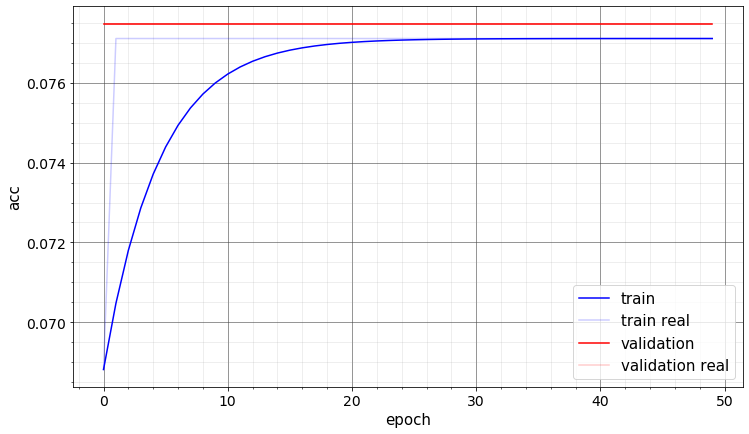

In [7]:
fig,ax=plt.subplots(figsize=(12,7))
ax.tick_params(labelsize=14)
plt.plot(smooth(history.history['categorical_accuracy']),color="Blue")
plt.plot(history.history['categorical_accuracy'],alpha=0.2,color="Blue")
plt.plot(smooth(history.history['val_categorical_accuracy']),color="Red")
plt.plot(history.history['val_categorical_accuracy'],alpha=0.2,color="Red")
plt.ylabel('acc',fontsize=15)
plt.xlabel('epoch',fontsize=15)
plt.grid(b=True, which='major', color='#444444', linestyle='-',alpha=0.7)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
#plt.yscale("log")
plt.legend(['train','train real', 'validation', 'validation real'], loc='lower right',fontsize=15)
plt.show()